In [57]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import google.generativeai
import ollama
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Markdown, display, update_display

In [6]:
class BasePlayer:
    def __init__(self, name, strategy):
        self.name = name
        #self.strategy = strategy
        self.history = []
        self.score = 0

    def reset(self):
        self.history = []

    def make_move(self, opponent_history): 
        raise NotImplementedError("Must implement in subclass.")

In [27]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

openai = OpenAI()
claude = anthropic.Anthropic()
google.generativeai.configure()

OLLAMA_API = "http://localhost:11434/api/chat"
MODEL = "llama3.2"

In [14]:
system_message = "You are a competitive computer scientist in a Prisoner's Dilemma Tournament"

user_prompt = """Please design a subclass for use as a strategy to represent you in a Prisoner's Dilemma Tournament based on the following class named BasePlayer:

    'class BasePlayer:
        def __init__(self, name, strategy):
            self.name = name
            #self.strategy = strategy
            self.history = []
            self.score = 0
    
        def reset(self):
            self.history = []
    
        def make_move(self, opponent_history): 
            raise NotImplementedError("Must implement in subclass.")'

    Some examples of potential subclasses are as follows where 'C' represents a choice to cooperate and 'D' represents a choice to defect in each round:

        1. A player who always cooperates:

            class AlwaysCooperatePlayer(BasePlayer):
                def make_move(self, opponent_history):
                    return 'C'

        2. A player who always defects:

            class AlwaysDefectPlayer(BasePlayer):
                def make_move(self, opponent_history):
                    return 'D'

        3. A traditional Tit-for-Tat strategy:

            class TitForTatPlayer(BasePlayer):
                def make_move(self, opponent_history):
                    return opponent_history[-1] if opponent_history else 'C'

        4. A Tit-for-Tat strategy with forgiveness:

            class ForgivingTitForTatPlayer(BasePlayer):
                def make_move(self, opponent_history):
                    if not opponent_history:
                        return 'C'
                    # Forgive if it's been 2+ peaceful turns
                    if opponent_history[-1] == 'D' and 'D' not in opponent_history[-3:]:
                        return 'C'
                    return opponent_history[-1]

    You will have access to your opponent's history but do not know how many rounds the game will last.

    The payoffs are as follows:
        1. If both players cooperate they each receive 5 points
        2. If both players defect they each receive 1 point
        3. If one player defects and one player cooperates, the defector will receive 5 points and the cooperator will receive 0 points

    Do not choose the traditional Tit-for-Tat strategy as that is just boring, but advanced Tit-for-Tat strategies with unique forgiveness or defect strategies methods are very welcome. 

    Please respond in the form of your class in python code.
    """

prompts = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_prompt}
  ]

#user_prompt

In [26]:
completion = openai.chat.completions.create(model='gpt-4o-mini', messages=prompts)
print(completion.choices[0].message.content)

Here's a subclass of `BasePlayer` that implements an advanced strategy known as "Win-Stay, Lose-Shift" with a twist for forgiveness. The idea behind this strategy is to maintain cooperation unless met with a defection, in which case it would shift strategies but also offer some level of forgiveness to encourage cooperation if the opponent shows remorse. 

```python
class WinStayLoseShiftPlayer(BasePlayer):
    def __init__(self, name):
        super().__init__(name, "Win-Stay, Lose-Shift")
        self.last_move = 'C'  # Start by cooperating
        self.consecutive_defections = 0

    def make_move(self, opponent_history):
        if not opponent_history:
            return 'C'  # First move is always to cooperate
        
        opponent_last_move = opponent_history[-1]
        
        if opponent_last_move == 'C':
            self.consecutive_defections = 0  # Reset on cooperation
            return 'C'  # Continue cooperating

        else:  # Opponent defected
            self.c

In [39]:
class WinStayLoseShiftPlayer(BasePlayer):
    def __init__(self, name):
        super().__init__(name, "Win-Stay, Lose-Shift")
        self.last_move = 'C'  # Start by cooperating
        self.consecutive_defections = 0

    def make_move(self, opponent_history):
        if not opponent_history:
            return 'C'  # First move is always to cooperate
        
        opponent_last_move = opponent_history[-1]
        
        if opponent_last_move == 'C':
            self.consecutive_defections = 0  # Reset on cooperation
            return 'C'  # Continue cooperating

        else:  # Opponent defected
            self.consecutive_defections += 1
            
            # Forgiveness: If there have been at least 2 cooperations in the last 4 turns
            if self.consecutive_defections < 2 and (
                opponent_history[-2:] == ['C', 'C'] or
                (len(opponent_history) > 2 and opponent_history[-3:-1] == ['C', 'C'])
            ):
                return 'C'  # Forgive and cooperate
            
            # If the opponent has defected consecutively, defect
            if self.consecutive_defections > 1:
                return 'D'  # Defect after being defected again

            return 'D'  # Default to defect after the first defection for 'Win-Stay, Lose-Shift'

In [37]:
message = claude.messages.create(
    model="claude-3-7-sonnet-latest",
    max_tokens=2000,
    temperature=0.7,
    system=system_message,
    messages=[
        {"role": "user", "content": user_prompt},
    ],
)

print(message.content[0].text)

```python
class AdaptivePatternPlayer(BasePlayer):
    def __init__(self, name="AdaptivePattern"):
        super().__init__(name, None)
        self.defect_threshold = 0.3
        self.forgiveness_chance = 0.05
        self.pattern_memory = {}
        self.last_moves = []
        self.pattern_length = 3
        self.trust_level = 0.5  # 0-1 scale, starts neutral
        
    def make_move(self, opponent_history):
        # Start with cooperation to establish trust
        if not opponent_history:
            return 'C'
        
        # Update trust level based on opponent's last move
        if opponent_history[-1] == 'C':
            self.trust_level = min(1.0, self.trust_level + 0.1)
        else:
            self.trust_level = max(0.0, self.trust_level - 0.2)
        
        # Track patterns in opponent's behavior
        if len(opponent_history) >= self.pattern_length:
            pattern = ''.join(opponent_history[-self.pattern_length:])
            if pattern not in self.patte

In [38]:
class AdaptivePatternPlayer(BasePlayer):
    def __init__(self, name="AdaptivePattern"):
        super().__init__(name, None)
        self.defect_threshold = 0.3
        self.forgiveness_chance = 0.05
        self.pattern_memory = {}
        self.last_moves = []
        self.pattern_length = 3
        self.trust_level = 0.5  # 0-1 scale, starts neutral
        
    def make_move(self, opponent_history):
        # Start with cooperation to establish trust
        if not opponent_history:
            return 'C'
        
        # Update trust level based on opponent's last move
        if opponent_history[-1] == 'C':
            self.trust_level = min(1.0, self.trust_level + 0.1)
        else:
            self.trust_level = max(0.0, self.trust_level - 0.2)
        
        # Track patterns in opponent's behavior
        if len(opponent_history) >= self.pattern_length:
            pattern = ''.join(opponent_history[-self.pattern_length:])
            if pattern not in self.pattern_memory:
                self.pattern_memory[pattern] = {'C': 0, 'D': 0}
            
            # If we can predict the next move based on pattern
            if len(opponent_history) > self.pattern_length:
                prev_pattern = ''.join(opponent_history[-(self.pattern_length+1):-1])
                if prev_pattern in self.pattern_memory:
                    self.pattern_memory[prev_pattern][opponent_history[-1]] += 1
        
        # Calculate defection rate of opponent
        defection_rate = opponent_history.count('D') / len(opponent_history)
        
        # Retaliation logic with pattern recognition
        if len(opponent_history) >= self.pattern_length:
            current_pattern = ''.join(opponent_history[-self.pattern_length:])
            if current_pattern in self.pattern_memory:
                c_count = self.pattern_memory[current_pattern]['C']
                d_count = self.pattern_memory[current_pattern]['D']
                total = c_count + d_count
                
                if total > 0:
                    # If opponent likely to defect after this pattern, preemptively defect
                    if d_count / total > 0.7:
                        return 'D'
        
        # Forgiveness mechanism - occasionally cooperate despite history
        if opponent_history[-1] == 'D' and random.random() < self.forgiveness_chance:
            return 'C'
            
        # Strategic defection based on opponent's behavior
        if defection_rate > self.defect_threshold:
            # More likely to defect against aggressive opponents
            defect_probability = defection_rate * (1 - self.trust_level)
            if random.random() < defect_probability:
                return 'D'
        
        # Detect if opponent might be using Tit-for-Tat
        if len(opponent_history) >= 3 and len(self.history) >= 3:
            tit_for_tat_count = 0
            for i in range(1, min(len(opponent_history), 5)):
                if opponent_history[-i] == self.history[-i-1]:
                    tit_for_tat_count += 1
            
            # If opponent seems to use TFT, occasionally defect to test
            if tit_for_tat_count >= 3 and random.random() < 0.1:
                return 'D'
        
        # Default to a trust-based response
        if self.trust_level > 0.6:
            return 'C'
        elif self.trust_level < 0.3:
            return 'D'
        else:
            # Mimic opponent's last move with high probability
            return opponent_history[-1]

In [21]:
gemini = google.generativeai.GenerativeModel(
    model_name='gemini-2.0-flash',
    system_instruction=system_message
)
response = gemini.generate_content(user_prompt)
print(response.text)

```python
import random

class BasePlayer:
    def __init__(self, name, strategy):
        self.name = name
        #self.strategy = strategy
        self.history = []
        self.score = 0

    def reset(self):
        self.history = []

    def make_move(self, opponent_history):
        raise NotImplementedError("Must implement in subclass.")

class AdaptiveTitForTat(BasePlayer):
    """
    A Tit-for-Tat variant that adjusts its behavior based on the opponent's observed
    cooperation rate.  If the opponent cooperates a lot, we cooperate more.
    If the opponent defects a lot, we become more aggressive.
    """
    def __init__(self, name, strategy="AdaptiveTitForTat", initial_cooperation_prob=0.9, adjustment_factor=0.1):
        super().__init__(name, strategy)
        self.cooperation_prob = initial_cooperation_prob  # Initial probability of cooperation
        self.adjustment_factor = adjustment_factor  # How much to adjust probability based on opponent behavior
        self.r

In [35]:
class AdaptiveTitForTat(BasePlayer):
    """
    A Tit-for-Tat variant that adjusts its behavior based on the opponent's observed
    cooperation rate.  If the opponent cooperates a lot, we cooperate more.
    If the opponent defects a lot, we become more aggressive.
    """
    def __init__(self, name, strategy="AdaptiveTitForTat", initial_cooperation_prob=0.9, adjustment_factor=0.1):
        super().__init__(name, strategy)
        self.cooperation_prob = initial_cooperation_prob  # Initial probability of cooperation
        self.adjustment_factor = adjustment_factor  # How much to adjust probability based on opponent behavior
        self.recent_history_length = 10 # Check the past X turns for cooperation rate

    def make_move(self, opponent_history):
        if not opponent_history:
            return 'C'  # Start by cooperating

        # Calculate opponent's cooperation rate in recent history
        recent_opponent_history = opponent_history[-self.recent_history_length:]
        cooperation_count = recent_opponent_history.count('C')
        cooperation_rate = cooperation_count / len(recent_opponent_history) if recent_opponent_history else 0.0

        # Adjust cooperation probability based on opponent's behavior
        if cooperation_rate > 0.6:  # Opponent is mostly cooperative
            self.cooperation_prob = min(1.0, self.cooperation_prob + self.adjustment_factor) # Increase cooperation
        elif cooperation_rate < 0.3:  # Opponent is mostly defecting
            self.cooperation_prob = max(0.1, self.cooperation_prob - self.adjustment_factor) # Decrease cooperation, but don't go below a minimum
        #otherwise keep cooperation probability the same

        # Tit-for-tat with adjusted cooperation probability
        if random.random() < self.cooperation_prob:
            #Consider what they did on the last turn
            if opponent_history[-1] == 'D':
                 return 'D'
            else:
                return 'C'

        else:
            return 'D' #Defect due to low probability of cooperation based on their history

In [25]:
response = ollama.chat(model=MODEL, messages=prompts)
print(response['message']['content'])

**Adaptive Forgiving Tit-for-Tat Strategy**

Here's an implementation of a variant of the Tit-for-Tat strategy that adapts to changing opponent behavior:

```python
class AdaptiveForgivingTitForTatPlayer(BasePlayer):
    def __init__(self, name, forgiveness_threshold=2):
        super().__init__(name, self)
        self.forgiveness_threshold = forgiveness_threshold
        self.turned_defector = False

    def make_move(self, opponent_history): 
        if not opponent_history:
            return 'C'

        last_cooperation = any(action == 'C' for action in opponent_history[-2:])
        last_defection = any(action == 'D' for action in opponent_history[-2:])

        if self.turned_defector and last_defection:
            self.turned_defector = False
            return 'C'

        if not self.turned_defector and last_cooperation:
            self.turned_defector = True
            return 'C'
        
        # Forgiveness check
        forgiveness_possible = ('D' not in opponent_his

In [ ]:
class AdaptiveForgivingTitForTatPlayer(BasePlayer):
    def __init__(self, name, forgiveness_threshold=2):
        super().__init__(name, self)
        self.forgiveness_threshold = forgiveness_threshold
        self.turned_defector = False

    def make_move(self, opponent_history): 
        if not opponent_history:
            return 'C'

        last_cooperation = any(action == 'C' for action in opponent_history[-2:])
        last_defection = any(action == 'D' for action in opponent_history[-2:])

        if self.turned_defector and last_defection:
            self.turned_defector = False
            return 'C'

        if not self.turned_defector and last_cooperation:
            self.turned_defector = True
            return 'C'
        
        # Forgiveness check
        forgiveness_possible = ('D' not in opponent_history[-3:]) and (last_cooperation or last_defection)

        if forgiveness_possible and not self.turned_defector:
            return 'C'

        return opponent_history[-1]

In [51]:
class RandomStrategy(BasePlayer):
    def __init__(self, name, strategy = 'RandomStrategy'):
        super().__init__(name, strategy) 

    def make_move(self, opponent_history):
        return random.choice(['C', 'D'])

In [40]:
def score_moves(move1, move2):
    if move1 == 'C' and move2 == 'C':
        return (3, 3)
    elif move1 == 'C' and move2 == 'D':
        return (0, 5)
    elif move1 == 'D' and move2 == 'C':
        return (5, 0)
    else:
        return (1, 1)

In [41]:
def play_iterated_game(p1, p2, rounds=5):
    p1.reset()
    p2.reset()
    for _ in range(rounds):
        move1 = p1.make_move(p2.history)
        move2 = p2.make_move(p1.history)
        p1.history.append(move1)
        p2.history.append(move2)
        s1, s2 = score_moves(move1, move2)
        p1.score += s1
        p2.score += s2

In [58]:
def run_tournament(players, rounds_per_game=50):
    score_history = defaultdict(list)

    for i, p1 in enumerate(players):
        for j, p2 in enumerate(players):
            if i >= j:
                continue  # Avoid duplicate or self matches

            # Reset histories
            p1.history, p2.history = [], []

            # Play match
            for _ in range(rounds_per_game):
                move1 = p1.make_move(p2.history)
                move2 = p2.make_move(p1.history)
                p1.history.append(move1)
                p2.history.append(move2)

                # Scoring logic (basic Prisoner's Dilemma payoff)
                if move1 == 'C' and move2 == 'C':
                    p1.score += 3
                    p2.score += 3
                elif move1 == 'C' and move2 == 'D':
                    p1.score += 0
                    p2.score += 5
                elif move1 == 'D' and move2 == 'C':
                    p1.score += 5
                    p2.score += 0
                else:
                    p1.score += 1
                    p2.score += 1

            # After the match, log cumulative scores
            for p in players:
                score_history[p.name].append(p.score)

    return score_history

In [59]:
def plot_score_history(score_history):
    plt.figure(figsize=(12, 6))

    for name, scores in score_history.items():
        plt.plot(scores, label=name, linewidth=2)

    plt.title("Score Over Time by Player")
    plt.xlabel("Match Number")
    plt.ylabel("Cumulative Score")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [66]:
players = [
    WinStayLoseShiftPlayer("OpenAI"),
    AdaptivePatternPlayer("Claude"),
    AdaptiveTitForTat("Gemini"),
    AdaptiveForgivingTitForTatPlayer("Ollama"),
    RandomStrategy("Chaos")
]

score_history = run_tournament(players, rounds_per_game=50)
final_scores = {name: scores[-1] for name, scores in score_history.items()}
sorted_final_scores = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)

print("\n🏆🏆 Final Scores: 🏆🏆")
for name, score in sorted_final_scores:
    print(f"{name}: {score}")


🏆🏆 Final Scores: 🏆🏆
Claude: 588
Gemini: 573
Ollama: 543
OpenAI: 540
Chaos: 493


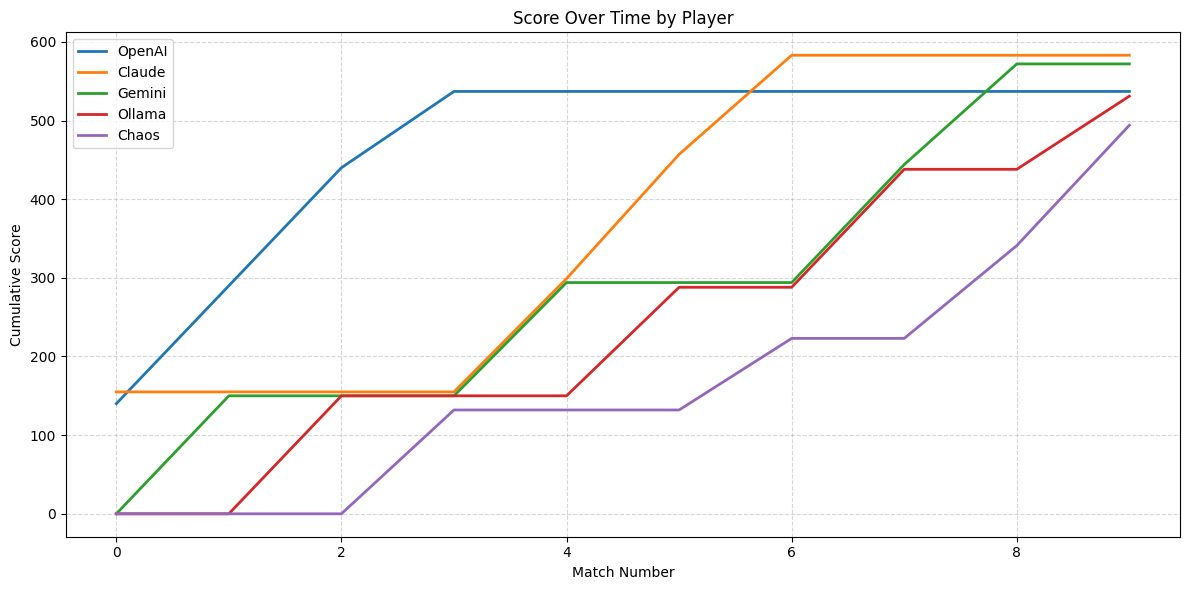

In [62]:
plot_score_history(score_history)